<a href="https://colab.research.google.com/github/un1tz3r0/finetunepixelartdiffusion/blob/main/training_diffusion_on_pixel_art_2026_02_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A simple colab to fine-tune openai diffusion models.

With some modifications to use my (isometric pixelart dataset)[https://github.com/un1tz3r0/pixelscapes-dataset] and auto-resume from the most recent model snapshot found on google drive, or start with kaliyuga's soft pixel art diffusion model otherwise.

Feel free to ask questions in this post's comments: https://www.patreon.com/posts/66246423

and questions specific to my pixelart fork here: https://github.com/un1tz3r0/finetunepixelartdiffusion

by [Alex Spirin](https://twitter.com/devdef)

iso pixelart fork by [Victor Condino](https://twitter.com/un1tz3r0)

![visitors](https://visitor-badge.glitch.me/badge?page_id=fine_tuning_openai_diffusion_model_on_iso_pixelart_ipynb)

#Train (tune) BEDROOM model :D
Needs 16gb GPU RAM

Works in colab pro and on kaggle

## Setup (run once per session)

This mounts your google drive for easier storage

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This downloads the training code and installs it, then downloads a pre-trained model that we will be tuning on our dataset

In [2]:
%cd /content
!git clone https://github.com/Sxela/guided-diffusion-sxela
%cd /content/guided-diffusion-sxela
!pip install -e .
%pip install mpi4py

/content
fatal: destination path 'guided-diffusion-sxela' already exists and is not an empty directory.
/content/guided-diffusion-sxela
Obtaining file:///content/guided-diffusion-sxela
  Preparing metadata (setup.py) ... done
  Attempting uninstall: guided-diffusion
    Found existing installation: guided-diffusion 0.0.0
    Uninstalling guided-diffusion-0.0.0:
      Successfully uninstalled guided-diffusion-0.0.0
  Running setup.py develop for guided-diffusion


In [3]:
#@title <big><big><big>Prepare **Isometric Pixelart Dataset**</big></big></big> { vertical-output: true, display-mode: "form" }

#@markdown Prepare the training image set from my github repo by randomly cropping  pixelscapes.

#@markdown ## Options:
#@markdown ---
generate_missing_dataset = True #@param {type:"boolean"}
#@markdown > Check this box to enable generating a new dataset from the images and script in my [pixelscapes-dataset repo](https://github.com/un1tz3r0/pixelscapes-dataset.git)
#@markdown ---
force_regenerate_dataset = False #@param {type:"boolean"}
#@markdown > Check this box to skip checking google drive for dataset.zip, and rebuild a new dataset from the pixelscapes-dataset repo's source images and randomcrops.py script. When done, the new dataset will be uploaded via rclone to Google Drive (as dataset.zip, an existing dataset.zip, if present, will be backed up)
#@markdown ---
generate_dataset_count = 25000 #@param {type:"integer"}
#@markdown > Size of the dataset to generate, in number of training images. These will be random crops from the source images, weighted by relative size so all pixels contribute equally to the training. When generating a new dataset from source images. output this many randomly cropped squares
#@markdown ---
upscale_factor =  1.0#@param {type:"number", min:1.0, max:4.0}
#@markdown > Zoom original images using a pretrained superresolution model with RealESRGAN by this factor before randomly cropping.
#@markdown ---
weighting_amount =  0.9 #@param {type:"number", min:0.0, max:1.0}
#@markdown > Amount of weighting based on source image size to use when sampling source images. 1.0=probability is proportional to ${width} \times {height}$, 0.0 = even probability
#@markdown ---
#unzip_dataset = True #@param {type: "boolean"}
##@markdown > Extract the dataset.zip to /content/dataset (needs patched StyleGAN3 train.py, which is used by this notebook already.)

dataset_name = "pixelscapes-256-{upscale_factor}x-{generate_dataset_count}"

drive_dataset_path = f"/content/drive/MyDrive/pixelscapes-datasets/{dataset_name}"

import os

if os.path.exists(drive_dataset_path):
  if os.path.exists("/content/dataset"):
    !rm -Rfv "/content/dataset"
  !cp -av $drive_dataset_path /content/dataset
else:
  # check if we need to generate a dataset from sources
  if (((not os.path.exists("/content/dataset.zip" )) and \
       (not os.path.exists("/content/dataset"))) and \
      generate_missing_dataset) or force_regenerate_dataset:
    print("Generating missing dataset from github repo now!")
    # create a new dataset.zip from the source images and randomcrop script in our github repo
    %cd '/content/'

    def install_realesrgan():
      %cd '/content/'
      # Clone Real-ESRGAN and enter the Real-ESRGAN
      !git clone https://github.com/xinntao/Real-ESRGAN.git
      %cd Real-ESRGAN
      !pip3 install -r requirements.txt
      !python3 setup.py develop --user
      # Download the pre-trained model
      !wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models

    def upscale_all(inputdir, outputdir, factor = 2.0):
      import pathlib
      outpath = pathlib.Path(outputdir).absolute()
      if not (outpath.exists() and outpath.is_dir()):
          outpath.mkdir()
      infiles = [f.absolute() for f in pathlib.Path(inputdir).glob("*.png")]
      for f in infiles:
        fin = str(f)
        fo = outpath / f.name
        if fo.exists():
            print(f"Skipping existing output file: {fo}")
            continue
            #fo = outpath / f"{fo.stem}-out.{fo.suffix}"
        fout = str(fo.parent.absolute())
        print(f"Upscaling x{factor}: {fin} -> {fout}")
        %cd /content/Real-ESRGAN
        if factor != 1.0:
          !python3 inference_realesrgan.py  -i $fin --outscale $factor -o $fout -n RealESRGAN_x4plus
        else:
          !ln -vs $fin $fout

    import os, pathlib
    if not pathlib.Path("pixelscapes-dataset").exists():
      !git clone https://github.com/un1tz3r0/pixelscapes-dataset.git
    else:
      %cd /content/pixelscapes-dataset
      !git diff --no-ext-diff --quiet --exit-code || rm -Rf cropped ../dataset.zip
      !git pull

    %cd /content
    if not os.path.exists("/content/pixelscapes-dataset/scaled/"):
    #if True:
      print(">>> Installing upscaler network to zoom 2x source images")
      install_realesrgan()
      print(">>> Upscaling raw dataset images...")
      upscale_all("/content/pixelscapes-dataset/pixelscapes/", \
                  "/content/pixelscapes-dataset/scaled", upscale_factor)
      print(">>> Done, now cropping from upscaled images...")

    %cd /content
    if not os.path.exists("/content/pixelscapes-dataset/cropped"):
      !python3 pixelscapes-dataset/randomcrops.py \
        pixelscapes-dataset/scaled \
        pixelscapes-dataset/cropped \
        --count $generate_dataset_count \
        --size 256 --weighting $weighting_amount

    if os.path.exists("/content/stylegan3/dataset_tool.py"):
      !python3 /content/stylegan3/dataset_tool.py \
        --source=pixelscapes-dataset/cropped \
        --dest=dataset.zip \
        --resolution='256x256'

      datasetpath = "/content/dataset.zip"
    else:
      datasetpath = "/content/dataset"

    if not os.path.exists(drive_dataset_path):
      #!cp -av /content/pixelscapes-dataset/cropped $drive_dataset_path
      pass

    # upload the newly created dataset
    #print("Syncing dataset.zip to drive...")
    #resultcode = rclone("syncto", "--progress", "/content/dataset.zip", "driveapi:/", output="pass", check=False)
    #if resultcode != 0:
    #  print(f"... not synced, result code is {resultcode}")
    #else:
    #  print("ok")

  '''
  !rm -rf /content/dataset
  # unzip the dataset.zip if needed and we have one
  if unzip_dataset and pathlib.Path("/content/dataset.zip").exists() and not (pathlib.Path("/content/dataset").exists() and pathlib.Path("/content/dataset").is_dir()):
    print("Unzipping dataset.zip to /content/dataset/...")
    import ipywidgets
    from IPython import display
    outw = widgets.Output()
    display.display(outw)
    import subprocess
    p = subprocess.Popen(["unzip", "-d/content/dataset", "/content/dataset.zip"], stdin=subprocess.PIPE, stdout=subprocess.PIPE)
    buf = bytes()
    lineno = 0
    while p.returncode is None:
      o, e = p.communicate(bytes())
      buf = buf + o
      lines = buf.splitlines()
      buf = lines[-1]
      lines = lines[0:-1]
      for line in lines:
        lineno = lineno + 1
        if lineno > 100:
          lineno = 0
          outw.clear_output(wait=True)
          with outw:
            print(line.strip().decode("utf8"), flush=True)
    print("done!")
    datasetpath = "/content/dataset"
'''


Generating missing dataset from github repo now!
/content
/content/pixelscapes-dataset
Already up to date.
/content
/content


# <big><big>Fine Tune</big></big>

<!-- For gigachads.
We're going to do what's called a pro-gamer move (or not): tune a small model, trained on rectilinear pixel art, on our own isometric pixelart dataset. Just because we can and it's much faster than training from scratch.

For, example here /content/drive/MyDrive/deep_learning/guided-diffusion-sxela/ - this path points to a location, where all the training checkpoints will be saved

and /content/YourDatasetHere/ - this path points to your dataset, i.e. a folder with images (no captions needed)
-->

We will be using this model together with CLIP inside DiscoDiffusion, so we can train less, stop early and let CLIP do the heavy lifting.

This will run almost forever, but you should start checking your results at around ~50k iterations. Good results begin to appear at 100-200k iterations, depending on your dataset.

Validating means opening your CHECKPOINT_PATH folder, taking the ema_0.9999_(some number of steps).pt file with the highest number (the latest one), going to this version of DiscoDiffusion here
https://github.com/Sxela/DiscoDiffusion-Warp/blob/main/Disco_Diffusion_v5_2_Warp_custom_model.ipynb and setting this: diffusion-model - custom, custom_path - path to that ema file from the previous step (if you saved it on google drive - then just point it there), and set width_height to 256x256, then run DD as usual


In [5]:
CHECKPOINT_PATH="/content/drive/MyDrive/deep_learning/guided-diffusion-sxela/"
import shlex

def latest_checkpoint(default_model):
  import pathlib, os
  try:
    def kf(f):
      return f.lstat().st_mtime
    f = str(list(sorted(list(pathlib.Path(CHECKPOINT_PATH).glob("ema_0.9999_*.pt")), key=kf))[-1])
    print(f"Resuming from latest checkpoint found: {f}")
    return f
  except Exception as err:
    print(f"Error finding latest checkpoint in {CHECKPOINT_PATH}: {err}")
    print(f"Resuming from default model: {default_model}")
    return default_model

RESUME_CHECKPOINT=latest_checkpoint("/content/pixel_art_diffusion_soft_256.pt")
MODEL_FLAGS="--image_size 256 --num_channels 128 --num_res_blocks 2 --num_heads 1 --learn_sigma True --use_scale_shift_norm False --attention_resolutions 16"
DIFFUSION_FLAGS="--diffusion_steps 1000 --noise_schedule linear --rescale_learned_sigmas False --rescale_timesteps False --use_scale_shift_norm False"
TRAIN_FLAGS=f"--lr 1e-4 --batch_size 4 --save_interval 1000 --log_interval 50 --resume_checkpoint {shlex.quote(RESUME_CHECKPOINT)}"
DATASET_PATH="/content/pixelscapes-dataset/cropped/" #change to point to your dataset path
%cd /content/guided-diffusion-sxela
!OPENAI_LOGDIR=$CHECKPOINT_PATH python scripts/image_train.py --data_dir $DATASET_PATH $MODEL_FLAGS $DIFFUSION_FLAGS $TRAIN_FLAGS

Streaming output truncated to the last 5000 lines.
| mse_q2     | 0.00548  |
| mse_q3     | 0.000303 |
| param_norm | 696      |
| samples    | 3.28e+04 |
| step       | 8.2e+03  |
| vb         | 0.000411 |
| vb_q0      | 0.00161  |
| vb_q1      | 0.00018  |
| vb_q2      | 4.87e-05 |
| vb_q3      | 3.63e-06 |
-------------------------
-------------------------
| grad_norm  | 0.0383   |
| loss       | 0.017    |
| loss_q0    | 0.0375   |
| loss_q1    | 0.0254   |
| loss_q2    | 0.00555  |
| loss_q3    | 0.000334 |
| mse        | 0.0166   |
| mse_q0     | 0.0359   |
| mse_q1     | 0.0252   |
| mse_q2     | 0.0055   |
| mse_q3     | 0.00033  |
| param_norm | 696      |
| samples    | 3.3e+04  |
| step       | 8.25e+03 |
| vb         | 0.000424 |
| vb_q0      | 0.00163  |
| vb_q1      | 0.000187 |
| vb_q2      | 4.89e-05 |
| vb_q3      | 3.9e-06  |
-------------------------
-------------------------
| grad_norm  | 0.0452   |
| loss       | 0.0178   |
| loss_q0    | 0.0421   |
| loss_q1    

KeyboardInterrupt: 

## Plot Progress


In [ ]:
columns = []
rows = []
data = {}

import csv
with open('/content/drive/MyDrive/deep_learning/guided-diffusion-sxela/progress.csv', newline='') as f:
    reader = csv.reader(f)
    for num, line in enumerate(reader):
        if num not in rows:
          rows.append(num)
        for col, val in line.items():
          if col not in data.keys():
            data[col] = {}
          data[col][num] = val


import matplotlib.pyplot as plt

for colname, coldata in data.items():
  plt.plot(list(coldata.keys()), list(coldata.values()), label=colname)
#y1 = [1, 3, 5, 3, 1, 3, 5, 3, 1]
#y2 = [2, 4, 6, 4, 2, 4, 6, 4, 2]
#plt.plot(x, y1, label="line L")
#plt.plot(x, y2, label="line H")
plt.plot()

plt.xlabel("x axis")
plt.ylabel("y axis")
plt.title("Line Graph Example")
plt.legend()
plt.show()

AttributeError: 'list' object has no attribute 'items'

## Sampling
The best way to sample your model in real-life conditions is to plug it into DiscoDiffusion.


Grab your latest ema checkpoint, open this colab here - https://github.com/Sxela/DiscoDiffusion-Warp/blob/main/Disco_Diffusion_v5_2_Warp_custom_model.ipynb

and change model settings > custom model path to your ema checkpoint's location, as described in the previous cell.

You can still sample using vanilla openai code, just plug your checkpoint in the cell below

Don't forget to change all the paths

Resuming from latest checkpoint found: /content/drive/MyDrive/deep_learning/guided-diffusion-sxela/ema_0.9999_020000.pt
/content/guided-diffusion-sxela
/content/guided-diffusion-sxela/guided_diffusion/nn.py:143: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @th.cuda.amp.custom_fwd
/content/guided-diffusion-sxela/guided_diffusion/nn.py:153: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @th.cuda.amp.custom_bwd
Logging to /content/drive/MyDrive/deep_learning/guided-diffusion-sxela/
creating model and diffusion...
sampling...
created 16 samples
saving to /content/drive/MyDrive/deep_learning/guided-diffusion-sxela/samples_8x256x256x3.npz
/usr/local/lib/python3.12/dist-packages/torch/distributed/distributed_c10d.py:4876: UserWarning: barrier(): using the device under current context. You can specify `devi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


### Sample no. 0:

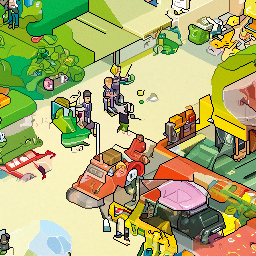

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


### Sample no. 1:

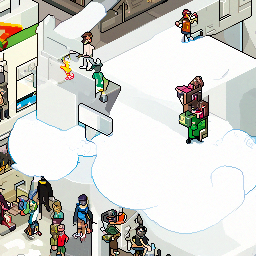

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


### Sample no. 2:

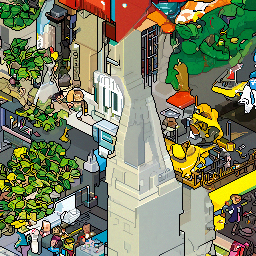

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


### Sample no. 3:

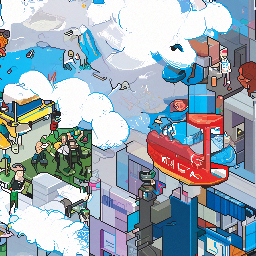

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


### Sample no. 4:

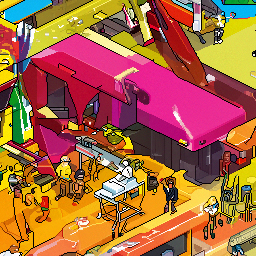

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


### Sample no. 5:

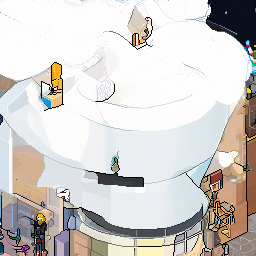

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


### Sample no. 6:

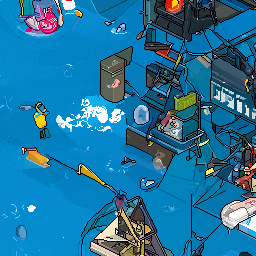

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


### Sample no. 7:

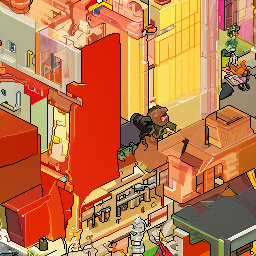

In [4]:
#checkpoint_path = 'input some checkpoint path here' #use ema checkpoint
CHECKPOINT_PATH="/content/drive/MyDrive/deep_learning/guided-diffusion-sxela/"
import shlex

def latest_checkpoint(default_model):
  import pathlib, os
  try:
    def kf(f):
      return f.lstat().st_mtime
    f = str(list(sorted(list(pathlib.Path(CHECKPOINT_PATH).glob("ema_0.9999_*.pt")), key=kf))[-1])
    print(f"Resuming from latest checkpoint found: {f}")
    return f
  except Exception as err:
    print(f"Error finding latest checkpoint in {CHECKPOINT_PATH}: {err}")
    print(f"Resuming from default model: {default_model}")
    return default_model

LATEST_CHECKPOINT=latest_checkpoint("/content/pixel_art_diffusion_soft_256.pt")
MODEL_FLAGS="--image_size 256 --num_channels 128 --num_res_blocks 2 --num_heads 1 --learn_sigma True --use_scale_shift_norm False --attention_resolutions 16"
DIFFUSION_FLAGS="--diffusion_steps 100 --noise_schedule linear --rescale_learned_sigmas False --rescale_timesteps True --use_scale_shift_norm False"
%cd /content/guided-diffusion-sxela
NUM_SAMPLES=8
!OPENAI_LOGDIR=$CHECKPOINT_PATH python scripts/image_sample.py --num_samples $NUM_SAMPLES --model_path {shlex.quote(LATEST_CHECKPOINT)} $MODEL_FLAGS $DIFFUSION_FLAGS --timestep_respacing ddim100

def show_samples(
    sample_path = f"/content/drive/MyDrive/deep_learning/guided-diffusion-sxela/samples_{NUM_SAMPLES}x256x256x3.npz",
    download_samples=True
    ):
  import numpy as np
  import PIL
  from google.colab import files
  from IPython.display import Image, Markdown

  sample_data = np.load(sample_path)
  for i in range(sample_data.f.arr_0.shape[0]):
    sample_img = PIL.Image.fromarray(sample_data.f.arr_0[i])
    sample_img.save(f"/content/sample_{i}.png")
    if download_samples:
      files.download(f"/content/sample_{i}.png")
    display(Markdown(f"\n### Sample no. {i}:"))
    display(Image(f"/content/sample_{i}.png"))

show_samples()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

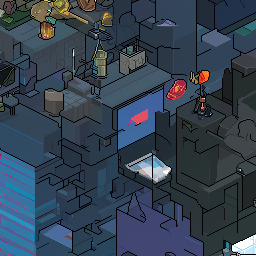

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

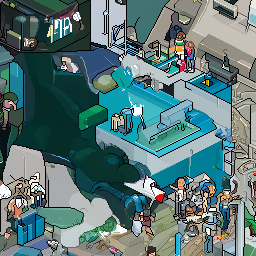

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

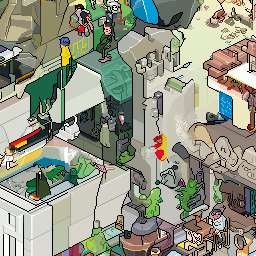

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

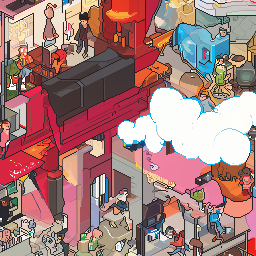

#Train (tune) 256x256 vanilla DD model
Only if you have a beefy GPU with more than 16gb RAM

For lvl 50 AI bosses,
Will not fit into colab pro, only in colab pro+ with A100 gpu


## Setup

This mounts your google drive for easier storage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

This downloads the training code and installs it, then downloads a pre-trained model that we will be tuning on our dataset.

I'm no using my edition of guided-diffusion in case you're going to use multiple GPUs

In [ ]:
%cd /content
!git clone https://github.com/openai/guided-diffusion
%cd /content/guided-diffusion
!pip install -e .
!pip install mpi4py
#is using on kaggle, replace !pip install mpi4py  with !conda install -y mpi4py
#download model checkpoint
!wget https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt -P /content/



## Tune

Don't forget to change the paths:
You need to change DATASET_PATH to point to your dataset images folder, and CHECKPOINT_PATH - to point to a folder you'd like to save progress to.

For, example here /content/drive/MyDrive/deep_learning/guided-diffusion-sxela/ - this path points to a location, where all the training checkpoints will be saved

and /content/YourDatasetHere/ - this path points to your dataset, i.e. a folder with images (no captions needed)




We will be using this model together with CLIP inside DiscoDiffusion, so we can train less, stop early and let CLIP do the heavy lifting.

This will run almost forever, but you should start checking your results at around ~50k iterations. Good results begin to appear at 100-200k iterations, depending on your dataset.

Validating means opening your CHECKPOINT_PATH folder, taking the ema_0.9999_(some number of steps).pt file with the highest number (the latest one), going to this version of DiscoDiffusion here
https://github.com/Sxela/DiscoDiffusion-Warp/blob/main/Disco_Diffusion_v5_2_Warp_custom_model.ipynb and setting this: diffusion-model - custom, custom_path - path to that ema file from the previous step (if you saved it on google drive - then just point it there),

you'll need to set custom model settings to this:

    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': diffusion_steps,
        'rescale_timesteps': True,
        'timestep_respacing': timestep_respacing,
        'image_size': 256,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 256,
        'num_head_channels': 64,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_checkpoint': use_checkpoint,
        'use_fp16': True,
        'use_scale_shift_norm': True,
    })

In [ ]:
MODEL_FLAGS="--attention_resolutions 32,16,8 --class_cond False --diffusion_steps 1000 --image_size 256 --learn_sigma True --noise_schedule linear --num_channels 256 --num_head_channels 64  --num_res_blocks 2 --resblock_updown True --use_fp16 True --use_scale_shift_norm True"
TRAIN_FLAGS="--lr 2e-5 --batch_size 4 --save_interval 1000 --log_interval 50 --resume_checkpoint /content/256x256_diffusion_uncond.pt"
DATASET_PATH="/content/YourDatasetHere/" #change to point to your dataset path
CHECKPOINT_PATH="/content/drive/MyDrive/deep_learning/guided-diffusion/"
%cd /content/guided-diffusion
!OPENAI_LOGDIR=$CHECKPOINT_PATH python scripts/image_train.py --data_dir $DATASET_PATH $MODEL_FLAGS $TRAIN_FLAGS

Sample from model

## Sampling
The best way to sample your model in real-life conditions is to plug it into DiscoDiffusion.


Grab your latest ema checkpoint, open this colab here - https://github.com/Sxela/DiscoDiffusion-Warp/blob/main/Disco_Diffusion_v5_2_Warp_custom_model.ipynb

and change settings like described in the previous cell

You can still sample using vanilla openai code, just plug your checkpoint in the cell below

Don't forget to change all the paths

In [ ]:
checkpoint_path = 'input some checkpoint path here'
!OPENAI_LOGDIR=/content/samples/  python scripts/image_sample.py --num_samples 1 --model_path $checkpoint_path $MODEL_FLAGS --timestep_respacing ddim100

Show results

In [ ]:
import numpy as np
import PIL

sample_path = 'some sample path'
im = np.load(sample_path)
PIL.Image.fromarray(im.f.arr_0[0])

# Train from scratch (smaller model)
For lvl 1 AI crooks like me, should fit into colab pro

Train a smaller model that will fit definitely into colab pro.

Don't forget to change the paths:
You need to change DATASET_PATH to point to your dataset images folder, and CHECKPOINT_PATH - to point to a folder you'd like to save progress to.

For, example here /content/drive/MyDrive/deep_learning/guided-diffusion-sxela/ - this path points to a location, where all the training checkpoints will be saved

and /content/YourDatasetHere/ - this path points to your dataset, i.e. a folder with images (no captions needed)




We will be using this model together with CLIP inside DiscoDiffusion, so we can train less, stop early and let CLIP do the heavy lifting.

This will run almost forever, but you should start checking your results at around ~50k iterations. Good results begin to appear at 100-200k iterations, depending on your dataset.

Validating means opening your CHECKPOINT_PATH folder, taking the ema_0.9999_(some number of steps).pt file with the highest number (the latest one), going to this version of DiscoDiffusion here
https://github.com/Sxela/DiscoDiffusion-Warp/blob/main/Disco_Diffusion_v5_2_Warp_custom_model.ipynb and setting this: diffusion-model - custom, custom_path - path to that ema file from the previous step (if you saved it on google drive - then just point it there),

you'll need to set custom model settings to this:

    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': diffusion_steps,
        'rescale_timesteps': True,
        'timestep_respacing': timestep_respacing,
        'image_size': 256,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 128,
        'num_heads': 4,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_checkpoint': use_checkpoint,
        'use_fp16': True,
        'use_scale_shift_norm': True,
    })

In [ ]:
MODEL_FLAGS="--attention_resolutions 32,16,8 --class_cond False --diffusion_steps 1000 --image_size 256 --learn_sigma True --noise_schedule linear --num_channels 128 --num_heads 4  --num_res_blocks 2 --resblock_updown True --use_fp16 True --use_scale_shift_norm True"
TRAIN_FLAGS="--lr 2e-5 --batch_size 4 --save_interval 1000 --log_interval 50"
DATASET_PATH="/content/YourDatasetHere/" #change to point to your dataset path
CHECKPOINT_PATH="/content/drive/MyDrive/deep_learning/guided-diffusion-sxela/"
%cd /content/guided-diffusion-sxela
!OPENAI_LOGDIR=$CHECKPOINT_PATH python scripts/image_train.py --data_dir $DATASET_PATH $MODEL_FLAGS $TRAIN_FLAGS

### Sampling
The best way to sample your model in real-life conditions is to plug it into DiscoDiffusion.


Grab your latest ema checkpoint, open this colab here - https://github.com/Sxela/DiscoDiffusion-Warp/blob/main/Disco_Diffusion_v5_2_Warp_custom_model.ipynb

and change settings like described in the previous cell

In [ ]:
checkpoint_path = 'input some checkpoint path here'
!OPENAI_LOGDIR=/content/samples/  python scripts/image_sample.py --num_samples 1 --model_path $checkpoint_path $MODEL_FLAGS --timestep_respacing ddim100

Show results

In [ ]:
import numpy as np
import PIL

sample_path = 'some sample path'
im = np.load(sample_path)
PIL.Image.fromarray(im.f.arr_0[0])